In [1]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git

Cloning into 'nnUNet'...
remote: Enumerating objects: 5914, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 5914 (delta 10), reused 18 (delta 2), pack-reused 5886
Receiving objects: 100% (5914/5914), 1.44 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (4671/4671), done.


## Importing Libraries

In [2]:
#run this 
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import PIL.Image as Image
import pydicom as dcm
from tqdm.notebook import tqdm
import wandb

import json

import torch
import shutil

import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader

import dicom2nifti 
import nibabel as nib

In [36]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [37]:
def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    f_path = checkpoint_dir / 'checkpoint.pt'
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_dir / 'best_model.pt'
        shutil.copyfile(f_path, best_fpath)

In [38]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1, 2'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

cuda


In [3]:
import os
base_dir = '/home/ubuntu/code/ab2'
os.chdir(base_dir)

In [4]:
import shutil
from collections import OrderedDict
import json
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os

base_dir='/home/ubuntu/code/ab2'
repository_dir=os.path.join(base_dir,'nnUNet')
print(repository_dir)
os.chdir(base_dir)

/home/ubuntu/code/ab2/nnUNet


In [5]:
print(os.getcwd())

/mnt/disk3/ubuntu/ab2


## Dataset Folder structure
#### Create folders in nnUnet as required 

In [4]:
def make_dir(folder_path,overwrite=False):
    """"folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder """
    
    if os.path.exists(folder_path):
        
        if not overwrite:
            print(f'{folder_path} exists.')
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")

In [6]:
task_name = 'Task606_Emphysema'
nnunet_dir = "nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_dir,task_name)
train_image_dir = os.path.join(task_folder_name,'imagesTr')
test_dir = os.path.join(task_folder_name,'imagesTs')
train_label_dir = os.path.join(task_folder_name,'labelsTr')
main_dir = os.path.join(base_dir,'nnUNet/nnunet')

In [9]:
run only once 

make_dir(task_folder_name,overwrite = False)
make_dir(train_image_dir)
make_dir(train_label_dir)
make_dir(test_dir,overwrite= False)
make_dir(os.path.join(main_dir,'nnunet_trained_models'))

nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task606_Emphysema created!
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task606_Emphysema/imagesTr created!
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task606_Emphysema/labelsTr created!
nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data/Task606_Emphysema/imagesTs created!
/home/ubuntu/code/ab2/nnUNet/nnunet/nnunet_trained_models created!


In [7]:
os.environ['nnUNet_raw_data_base'] = os.path.join(main_dir,'nnUNet_raw_data_base')
os.environ['nnUNet_preprocessed'] = os.path.join(main_dir,'preprocessed')
os.environ['RESULTS_FOLDER'] = os.path.join(main_dir,'nnUNet_trained_models')

In [8]:
import os
list_img_tr = os.listdir(train_image_dir)
print(len(list_img_tr))

list_img_ts = os.listdir(test_dir)
print(len(list_img_ts))

print(len(os.listdir(train_label_dir)))

demoll = '/home/ubuntu/code/ab2/nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_cropped_data/Task606_Emphysema'
print(len(os.listdir(demoll)))

930
233
929
1862


## dataset.json

In [46]:
overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = task_name
    json_dict['description'] = "Emphysema detection - PMX project1"
    json_dict['tensorImageSize'] = "3D"
    json_dict['reference'] = "NA"
    json_dict['licence'] = "NA"
    json_dict['release'] = "NA"


#     you may mention more than one modality
    json_dict['modality'] = {
        "0": "CT"
    }
    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "0": "background",
        "1": "emphysema",
#         "2": "white matter"
    }
    
    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)

    #no modality in train image and labels in dataset.json 
    json_dict['training'] = [{'image': "./imagesTr/%s" % i, "label": "./labelsTr/%s" % i} for i in train_ids]

    #removing the modality from test image name to be saved in dataset.json
#     json_dict['test'] = ["./imagesTs/%s" % (i[:i.find("_0000")]+'.nii.gz') for i in test_ids]
    json_dict['test'] = ["./imagesTs/%s" % (i[:i.find("_0000")]+'.nii.gz') for i in test_ids]

    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json already exist!
dataset.json overwritten!


## setting up path 

In [9]:
#    Copyright 2020 Division of Medical Image Computing, German Cancer Research Center (DKFZ), Heidelberg, Germany
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.

import os
from batchgenerators.utilities.file_and_folder_operations import maybe_mkdir_p, join

# do not modify these unless you know what you are doing
my_output_identifier = "nnUNet"
default_plans_identifier = "nnUNetPlansv2.1"
default_data_identifier = 'nnUNetData_plans_v2.1'
default_trainer = "nnUNetTrainerV2"
default_cascade_trainer = "nnUNetTrainerV2CascadeFullRes"

"""
PLEASE READ paths.md FOR INFORMATION TO HOW TO SET THIS UP
"""

base = os.environ['nnUNet_raw_data_base'] if "nnUNet_raw_data_base" in os.environ.keys() else None
preprocessing_output_dir = os.environ['nnUNet_preprocessed'] if "nnUNet_preprocessed" in os.environ.keys() else None
network_training_output_dir_base = os.path.join(os.environ['RESULTS_FOLDER']) if "RESULTS_FOLDER" in os.environ.keys() else None

if base is not None:
    nnUNet_raw_data = join(base, "nnUNet_raw_data")
    nnUNet_cropped_data = join(base, "nnUNet_cropped_data")
    maybe_mkdir_p(nnUNet_raw_data)
    maybe_mkdir_p(nnUNet_cropped_data)
else:
    print("nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files "
          "are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like "
          "this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.")
    nnUNet_cropped_data = nnUNet_raw_data = None

if preprocessing_output_dir is not None:
    maybe_mkdir_p(preprocessing_output_dir)
else:
    print("nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing "
          "or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.")
    preprocessing_output_dir = None

if network_training_output_dir_base is not None:
    network_training_output_dir = join(network_training_output_dir_base, my_output_identifier)
    maybe_mkdir_p(network_training_output_dir)
else:
    print("RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or "
          "inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this "
          "up.")
    network_training_output_dir = None

## experiment preplanning and processing 

In [12]:
run only once 

import nnunet
from batchgenerators.utilities.file_and_folder_operations import *
from nnunet.experiment_planning.DatasetAnalyzer import DatasetAnalyzer
from nnunet.experiment_planning.utils import crop
from nnunet.paths import *
import shutil
from nnunet.utilities.task_name_id_conversion import convert_id_to_task_name
from nnunet.preprocessing.sanity_checks import verify_dataset_integrity
from nnunet.training.model_restore import recursive_find_python_class


def main():
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("-t", "--task_ids", nargs="+", help="List of integers belonging to the task ids you wish to run"
                                                            " experiment planning and preprocessing for. Each of these "
                                                            "ids must, have a matching folder 'TaskXXX_' in the raw "
                                                            "data folder")
    parser.add_argument("-pl3d", "--planner3d", type=str, default="ExperimentPlanner3D_v21",
                        help="Name of the ExperimentPlanner class for the full resolution 3D U-Net and U-Net cascade. "
                             "Default is ExperimentPlanner3D_v21. Can be 'None', in which case these U-Nets will not be "
                             "configured")
    parser.add_argument("-pl2d", "--planner2d", type=str, default="ExperimentPlanner2D_v21",
                        help="Name of the ExperimentPlanner class for the 2D U-Net. Default is ExperimentPlanner2D_v21. "
                             "Can be 'None', in which case this U-Net will not be configured")
    parser.add_argument("-no_pp", action="store_true",
                        help="Set this flag if you dont want to run the preprocessing. If this is set then this script "
                             "will only run the experiment planning and create the plans file")
    parser.add_argument("-tl", type=int, required=False, default=8,
                        help="Number of processes used for preprocessing the low resolution data for the 3D low "
                             "resolution U-Net. This can be larger than -tf. Don't overdo it or you will run out of "
                             "RAM")
    parser.add_argument("-tf", type=int, required=False, default=8,
                        help="Number of processes used for preprocessing the full resolution data of the 2D U-Net and "
                             "3D U-Net. Don't overdo it or you will run out of RAM")
    parser.add_argument("--verify_dataset_integrity", required=False, default=False, action="store_true",
                        help="set this flag to check the dataset integrity. This is useful and should be done once for "
                             "each dataset!")
    parser.add_argument("-overwrite_plans", type=str, default=None, required=False,
                        help="Use this to specify a plans file that should be used instead of whatever nnU-Net would "
                             "configure automatically. This will overwrite everything: intensity normalization, "
                             "network architecture, target spacing etc. Using this is useful for using pretrained "
                             "model weights as this will guarantee that the network architecture on the target "
                             "dataset is the same as on the source dataset and the weights can therefore be transferred.\n"
                             "Pro tip: If you want to pretrain on Hepaticvessel and apply the result to LiTS then use "
                             "the LiTS plans to run the preprocessing of the HepaticVessel task.\n"
                             "Make sure to only use plans files that were "
                             "generated with the same number of modalities as the target dataset (LiTS -> BCV or "
                             "LiTS -> Task008_HepaticVessel is OK. BraTS -> LiTS is not (BraTS has 4 input modalities, "
                             "LiTS has just one)). Also only do things that make sense. This functionality is beta with"
                             "no support given.\n"
                             "Note that this will first print the old plans (which are going to be overwritten) and "
                             "then the new ones (provided that -no_pp was NOT set).")
    parser.add_argument("-overwrite_plans_identifier", type=str, default=None, required=False,
                        help="If you set overwrite_plans you need to provide a unique identifier so that nnUNet knows "
                             "where to look for the correct plans and data. Assume your identifier is called "
                             "IDENTIFIER, the correct training command would be:\n"
                             "'nnUNet_train CONFIG TRAINER TASKID FOLD -p nnUNetPlans_pretrained_IDENTIFIER "
                             "-pretrained_weights FILENAME'")
    parser.add_argument('-f')

    args = parser.parse_args()
    task_ids = args.task_ids
    dont_run_preprocessing = args.no_pp
    tl = args.tl
    tf = args.tf
    planner_name3d = args.planner3d
    planner_name2d = args.planner2d

    if planner_name3d == "None":
        planner_name3d = None
    if planner_name2d == "None":
        planner_name2d = None

    if args.overwrite_plans is not None:
        if planner_name2d is not None:
            print("Overwriting plans only works for the 3d planner. I am setting '--planner2d' to None. This will "
                  "skip 2d planning and preprocessing.")
        assert planner_name3d == 'ExperimentPlanner3D_v21_Pretrained', "When using --overwrite_plans you need to use " \
                                                                       "'-pl3d ExperimentPlanner3D_v21_Pretrained'"

    # we need raw data
    tasks = []
    task_ids=["606"]
#     print(type(task_ids))
    for i in task_ids:
        i = int(i)

        task_name = convert_id_to_task_name(i)

        if args.verify_dataset_integrity:
            verify_dataset_integrity(join(nnUNet_raw_data, task_name))

        crop(task_name, False, tf)

        tasks.append(task_name)

    search_in = join(nnunet.__path__[0], "experiment_planning")

    if planner_name3d is not None:
        planner_3d = recursive_find_python_class([search_in], planner_name3d, current_module="nnunet.experiment_planning")
        if planner_3d is None:
            raise RuntimeError("Could not find the Planner class %s. Make sure it is located somewhere in "
                               "nnunet.experiment_planning" % planner_name3d)
    else:
        planner_3d = None

    if planner_name2d is not None:
        planner_2d = recursive_find_python_class([search_in], planner_name2d, current_module="nnunet.experiment_planning")
        if planner_2d is None:
            raise RuntimeError("Could not find the Planner class %s. Make sure it is located somewhere in "
                               "nnunet.experiment_planning" % planner_name2d)
    else:
        planner_2d = None

    for t in tasks:
        print("\n\n\n", t)
        cropped_out_dir = os.path.join(nnUNet_cropped_data, t)
        preprocessing_output_dir_this_task = os.path.join(preprocessing_output_dir, t)
        #splitted_4d_output_dir_task = os.path.join(nnUNet_raw_data, t)
        #lists, modalities = create_lists_from_splitted_dataset(splitted_4d_output_dir_task)

        # we need to figure out if we need the intensity propoerties. We collect them only if one of the modalities is CT
        dataset_json = load_json(join(cropped_out_dir, 'dataset.json'))
        modalities = list(dataset_json["modality"].values())
        collect_intensityproperties = True if (("CT" in modalities) or ("ct" in modalities)) else False
        dataset_analyzer = DatasetAnalyzer(cropped_out_dir, overwrite=False, num_processes=tf)  # this class creates the fingerprint
        _ = dataset_analyzer.analyze_dataset(collect_intensityproperties)  # this will write output files that will be used by the ExperimentPlanner


        maybe_mkdir_p(preprocessing_output_dir_this_task)
        shutil.copy(join(cropped_out_dir, "dataset_properties.pkl"), preprocessing_output_dir_this_task)
        shutil.copy(join(nnUNet_raw_data, t, "dataset.json"), preprocessing_output_dir_this_task)

        threads = (tl, tf)

        print("number of threads: ", threads, "\n")

        if planner_3d is not None:
            if args.overwrite_plans is not None:
                assert args.overwrite_plans_identifier is not None, "You need to specify -overwrite_plans_identifier"
                exp_planner = planner_3d(cropped_out_dir, preprocessing_output_dir_this_task, args.overwrite_plans,
                                         args.overwrite_plans_identifier)
            else:
                exp_planner = planner_3d(cropped_out_dir, preprocessing_output_dir_this_task)
            exp_planner.plan_experiment()
            if not dont_run_preprocessing:  # double negative, yooo
                exp_planner.run_preprocessing(threads)
        if planner_2d is not None:
            exp_planner = planner_2d(cropped_out_dir, preprocessing_output_dir_this_task)
            exp_planner.plan_experiment()
            if not dont_run_preprocessing:  # double negative, yooo
                exp_planner.run_preprocessing(threads)


if __name__ == "__main__":
    main()






Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

00410130004104570080034500410980004098570040987300409391



0080095500408114

008021550010732600410164



0010972000107249

00108071_600800465

004085940040869800801925

00408519
00107771
0040988100802421
00107798

00410233
00408551

00310331_2
00406949
0030684900410947003094990040663000801057
00310306



00409641
008030640011052700801521
00107891
00107694



00109634
0080320200108776003126140011064700407376

00410148_3

00107188


00313102
0010744600107704

00802208
003109590080345100311197
00409280

00110088
00409753
00407411
00801744
00308049


0080150400802499
00406768004112030080209400312287
00107153

00410894

00408269008022

### Visualise Training and Label Dataset

00800250_0000.nii.gz
(512, 512, 5) (512, 512, 5)
00800250.nii.gz


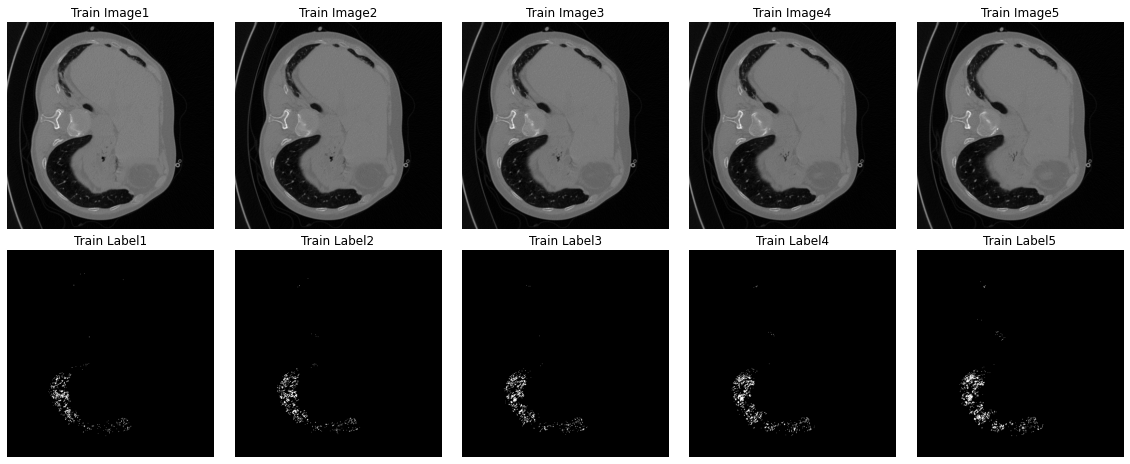

In [11]:
#for images
train_img_name = os.listdir(train_image_dir)[np.random.randint(0,len(list_img_tr))]
train_img = np.array(nib.load(os.path.join(train_image_dir,train_img_name)).dataobj)[:,:, 100:105]

#for labels
train_label_name = train_img_name[:train_img_name.find('_0000.nii.gz')]+'.nii.gz'
train_label = np.array(nib.load(os.path.join(train_label_dir,train_label_name)).dataobj)[:,:,100:105]


print(train_img_name)
# print(train_img.shape)
print(train_img.shape,train_label.shape)

print(train_label_name)
# print(train_label)


max_rows = 2

max_cols = train_img.shape[2]

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
for idx in range(max_cols):
    axes[0, idx].axis("off") 
    axes[0, idx].set_title('Train Image'+str(idx+1))
    axes[0 ,idx].imshow(train_img[:,:,idx], cmap="gray")
for idx in range(max_cols):    
    axes[1, idx].axis("off")
    axes[1, idx].set_title('Train Label'+str(idx+1))
    axes[1, idx].imshow(train_label[:,:,idx], cmap="gray")

plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

## Testing

00802301_0000.nii.gz
(512, 512, 5)


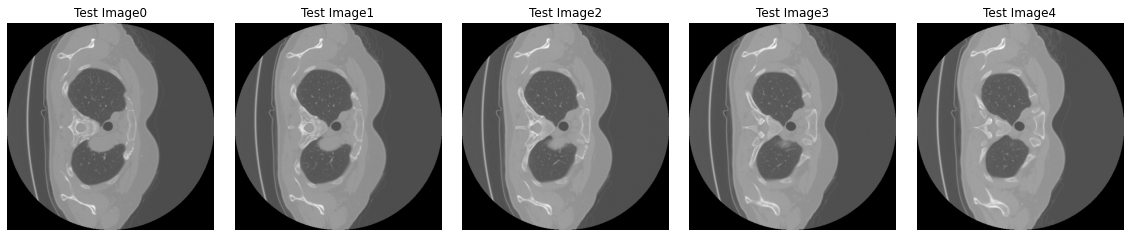

In [12]:
test_img_name = os.listdir(test_dir)[np.random.randint(0,len(list_img_ts))]
test_img = np.array(nib.load(os.path.join(test_dir,test_img_name)).dataobj)[:,:,100:105]

print(test_img_name)
print(test_img.shape)

max_cols = test_img.shape[2]
max_rows = 1

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,20))
for idx in range(max_cols):
    axes[idx].axis("off") 
    axes[idx].set_title('Test Image'+str(idx))
    axes[idx].imshow(test_img[:,:,idx], cmap="gray")
    
    
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

In [20]:
# !nnUNet_plan_and_preprocess -t 606 

In [19]:
!pip install graphviz 
import graphviz 

# Training

### benchmark 5 epochs

In [12]:
!nnUNet_train 3d_fullres nnUNetTrainerV2_5epochs 606 0 



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNet_variants.benchmarking.nnUNetTrainerV2_2epochs.nnUNetTrainerV2_5epochs'>
For that I will be using the following configuration:
num_classes:  1
modalities:  {0: 'CT'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'CT')])
stages...

stage:  0
{'batch_size': 2, 'num_pool_per_axis': [4, 5, 5], 'patch_size': array([ 96, 160, 160]), 'median_patient_size_in_

### 1000 epochs training 

In [90]:
# import torch
# foo = torch.tensor([1,2,3])
# foo = foo.to('cuda')

In [ ]:
!nnUNet_train 3d_fullres nnUNetTrainerV2 606 0



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainerV2'>
For that I will be using the following configuration:
num_classes:  1
modalities:  {0: 'CT'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'CT')])
stages...

stage:  0
{'batch_size': 2, 'num_pool_per_axis': [4, 5, 5], 'patch_size': array([ 96, 160, 160]), 'median_patient_size_in_voxels': array([153, 250, 250]), 'current_spa

In [ ]:
!nnUNet_train 3d_fullres nnUNetTrainerV2 606 0 -c



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

###############################################
I am running the following nnUNet: 3d_fullres
My trainer class is:  <class 'nnunet.training.network_training.nnUNetTrainerV2.nnUNetTrainerV2'>
For that I will be using the following configuration:
num_classes:  1
modalities:  {0: 'CT'}
use_mask_for_norm OrderedDict([(0, False)])
keep_only_largest_region None
min_region_size_per_class None
min_size_per_class None
normalization_schemes OrderedDict([(0, 'CT')])
stages...

stage:  0
{'batch_size': 2, 'num_pool_per_axis': [4, 5, 5], 'patch_size': array([ 96, 160, 160]), 'median_patient_size_in_voxels': array([153, 250, 250]), 'current_spa

# 

## Inference Code 

In [10]:
result_dir = os.path.join(main_dir,'nnUNet_Prediction_Results',task_name)
make_dir(result_dir)
team_name = 'PMX_Project1'

/home/ubuntu/code/ab2/nnUNet/nnunet/nnUNet_Prediction_Results/Task606_Emphysema exists.


In [13]:
os.chdir(main_dir)
!nnUNet_predict -i nnUNet_raw_data_base/nnUNet_raw_data/Task606_Emphysema/imagesTs -o nnUNet_Prediction_Results/Task606_Emphysema -t 606 -tr nnUNetTrainerV2 -m 3d_fullres --num_threads_preprocessing 1
os.chdir(base_dir)



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

using model stored in  /home/ubuntu/code/ab2/nnUNet/nnunet/nnUNet_trained_models/nnUNet/3d_fullres/Task606_Emphysema/nnUNetTrainerV2__nnUNetPlansv2.1
This model expects 1 input modalities for each image
Found 232 unique case ids, here are some examples: ['00801659' '00407522' '00800490' '00410758' '00108510' '00312417'
 '00311455' '00309842' '00310701' '00310623']
If they don't look right, make sure to double check your filenames. They must end with _0000.nii.gz etc
number of cases: 232
number of cases that still need to be predicted: 0
emptying cuda cache
loading parameters for folds, None
folds is None so we will automatically l

## Prediction Visualisation 

00801297_0000.nii.gz
00801297.nii.gz
(512, 512, 5) (512, 512, 5)


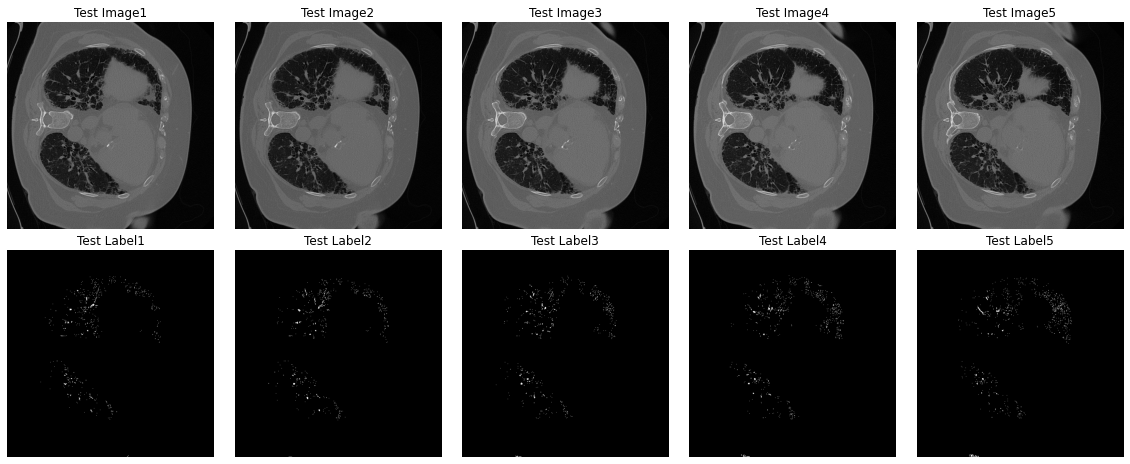

In [30]:
prediction_dir ="/home/ubuntu/code/ab2/nnUNet/nnunet/nnUNet_Prediction_Results/Task606_Emphysema"

test_img_name =  os.listdir(test_dir)[np.random.randint(0,len(list_img_ts))]
test_img = np.array(nib.load(os.path.join(test_dir , test_img_name)).dataobj)[:,:, 100:105]

test_label_name = test_img_name[:test_img_name.find('_0000.nii.gz')]+'.nii.gz'
test_label = np.array(nib.load(os.path.join(prediction_dir,test_label_name)).dataobj)[:,:,100:105]

print(test_img_name)
print(test_label_name)
print(test_img.shape,test_label.shape)

max_rows = 2

max_cols = test_img.shape[2]

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
for idx in range(max_cols):
    axes[0, idx].axis("off") 
    axes[0, idx].set_title('Test Image'+str(idx+1))
    axes[0 ,idx].imshow(test_img[:,:,idx], cmap="gray")
for idx in range(max_cols):    
    axes[1, idx].axis("off")
    axes[1, idx].set_title('Test Label'+str(idx+1))
    axes[1, idx].imshow(test_label[:,:,idx], cmap="gray")

plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()